## Random Forest

Random Forest is an ensemble of Decision Trees. With a few exceptions, a `RandomForestClassifier` has all the hyperparameters of a `DecisionTreeClassifier` (to control how trees are grown), plus all the hyperparameters of a `BaggingClassifier` to control the ensemble itself.

The Random Forest algorithm introduces extra randomness when growing trees; instead of searching for the very best feature when splitting a node, it searches for the best feature among a random subset of features. This results in a greater tree diversity, which (once again) trades a higher bias for a lower variance, generally yielding an overall better model. The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`. Run the cell below to visualize a single estimator from a random forest model, using the Iris dataset to classify the data into the appropriate species.

In [4]:
from sklearn.datasets import load_iris
iris = load_iris()

# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=10)

# Train
model.fit(iris.data, iris.target)
# Extract single tree
estimator = model.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

Notice how each split seperates the data into buckets of similar observations. This is a single tree and a relatively simple classification dataset, but the same method is used in a more complex dataset with greater depth to the trees.

## Coronavirus
Coronavirus disease (COVID-19) is an infectious disease caused by a new virus.
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. You can protect yourself by washing your hands frequently, avoiding touching your face, and avoiding close contact (1 meter or 3 feet) with people who are unwell. An outbreak of COVID-19 started in December 2019 and at the time of the creation of this project was continuing to spread throughout the world. Many governments recommended only essential outings to public places and closed most business that do not serve food or sell essential items. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins shows the daily confirmed cases by country. 

This case study was designed to drive home the important role that data science plays in real-world situations like this pandemic. This case study uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19 provided on [Kaggle](https://www.kaggle.com/kimjihoo/coronavirusdataset) to encourage research on this important topic. The goal of the case study is to build a Random Forest Classifier to predict the 'state' of the patient.

First, please load the needed packages and modules into Python. Next, load the data into a pandas dataframe for ease of use.

In [1]:
import os
import pandas as pd
from datetime import datetime,timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

ModuleNotFoundError: No module named 'plotly'

In [2]:
url ='PatientInfo.csv'
df = pd.read_csv(url)
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [3]:
df.index = df['patient_id']

del df['patient_id']

In [4]:
df.shape

(2218, 17)

In [5]:
df.head()

,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
patient_id,,,,,,,,,,,,,,,,,
1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


In [6]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [7]:
#counts of response variable values
df.state.value_counts()

isolated    1791
released     307
deceased      32
Name: state, dtype: int64

 **<font color='teal'> Create a new column named 'n_age' which is the calculated age based on the birth year column.</font>**

In [8]:
df['n_age'] = 2020 - df['birth_year']


In [9]:
df.head()

,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age
patient_id,,,,,,,,,,,,,,,,,,
1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released,56.0
1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released,33.0
1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released,56.0
1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released,29.0
1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released,28.0


### Handle Missing Values

 **<font color='teal'> Print the number of missing values by column.</font>**

In [10]:
#Counts of null values 
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [11]:
df['disease'].value_counts()

True    19
Name: disease, dtype: int64

 **<font color='teal'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [12]:
df['disease'].fillna(value=0, inplace=True)
df.disease[df.disease == True] = 1

<ipython-input-12-a0ced7813019>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.disease[df.disease == True] = 1


In [13]:
df['disease'].value_counts()

0    2199
1      19
Name: disease, dtype: int64

 **<font color='teal'> Fill null values in the following columns with their mean: 'global_number','birth_year','infection_order','infected_by'and 'contact_number'</font>**

In [14]:
cols = ['global_num', 'birth_year', 'infection_order', 'infected_by', 'contact_number']

np.mean(df['global_num'])

for i in cols:
    mean = np.mean(df[i])
    df[i].fillna(mean, inplace=True)


 **<font color='teal'> Fill the rest of the missing values with any method.</font>**

In [15]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,2186
1,symptom_onset_date,2025
2,released_date,1995
3,infection_case,1055
4,n_age,454
5,age,261
6,sex,145
7,confirmed_date,141
8,state,88
9,city,65


In [16]:
cols = ['sex', 'age', 'city', 'infection_case', 'state', 'n_age']

for i in cols:
    df[i].fillna(value='Unknown', inplace=True)


 **<font color='teal'> Check for any remaining null values.</font>**

In [17]:
na_df=pd.DataFrame(df.isnull().sum().sort_values(ascending=False)).reset_index()
na_df.columns = ['VarName', 'NullCount']
na_df[(na_df['NullCount']>0)]

,VarName,NullCount
0,deceased_date,2186
1,symptom_onset_date,2025
2,released_date,1995
3,confirmed_date,141


Remove date columns from the data.


In [18]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2218 entries, 1000000001 to 7000000004
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   global_num       2218 non-null   float64
 1   sex              2218 non-null   object 
 2   birth_year       2218 non-null   float64
 3   age              2218 non-null   object 
 4   country          2218 non-null   object 
 5   province         2218 non-null   object 
 6   city             2218 non-null   object 
 7   disease          2218 non-null   object 
 8   infection_case   2218 non-null   object 
 9   infection_order  2218 non-null   float64
 10  infected_by      2218 non-null   float64
 11  contact_number   2218 non-null   float64
 12  state            2218 non-null   object 
 13  n_age            2218 non-null   object 
dtypes: float64(5), object(9)
memory usage: 259.9+ KB


In [20]:
df.head()

,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
patient_id,,,,,,,,,,,,,,
1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,56
1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,33
1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56
1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,29
1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28


Review the count of unique values by column.

In [22]:
print(df.nunique())

global_num         1304
sex                   3
birth_year           97
age                  12
country               4
province             17
city                135
disease               2
infection_case       17
infection_order       7
infected_by         207
contact_number       73
state                 4
n_age                97
dtype: int64


Review the percent of unique values by column.

In [23]:
print(df.nunique()/df.shape[0])

global_num         0.587917
sex                0.001353
birth_year         0.043733
age                0.005410
country            0.001803
province           0.007665
city               0.060866
disease            0.000902
infection_case     0.007665
infection_order    0.003156
infected_by        0.093327
contact_number     0.032913
state              0.001803
n_age              0.043733
dtype: float64


Review the range of values per column.

In [33]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
global_num,1981.0,4.664817e+03,2.340417e+03,1.000000e+00,3.680000e+03,4.664817e+03,6.317000e+03,8.717000e+03
birth_year,1981.0,1.975034e+03,1.823767e+01,1.916000e+03,1.964000e+03,1.974989e+03,1.991000e+03,2.020000e+03
infection_order,1981.0,2.285714e+00,1.805875e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
infected_by,1981.0,2.600032e+09,7.628570e+08,1.000000e+09,2.600789e+09,2.600789e+09,2.600789e+09,6.113000e+09
contact_number,1981.0,2.414928e+01,4.144453e+01,0.000000e+00,2.412895e+01,2.412895e+01,2.412895e+01,1.160000e+03


### Check for duplicated rows

In [34]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
patient_id,,,,,,,,,,,,,,


In [35]:
df = df.drop_duplicates()

In [36]:
df.shape

(1981, 14)

Print the categorical columns and their associated levels.

In [55]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
dfo.shape
print(dfo.columns)

dff = df.select_dtypes(include=['float'], exclude=['datetime', 'object'])
dff['state'] = df['state']
print(dff.columns)

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

Index(['sex', 'age', 'country', 'province', 'city', 'disease',
       'infection_case', 'state', 'n_age'],
      dtype='object')
Index(['global_num', 'birth_year', 'infection_order', 'infected_by',
       'contact_number', 'state'],
      dtype='object')


<ipython-input-55-fea7ff4bac82>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dff['state'] = df['state']


,VarName,LevelsCount
0,sex,3
1,age,12
2,country,4
3,province,17
4,city,135
5,disease,2
6,infection_case,17
7,state,4
8,n_age,97


**<font color='teal'> Plot the correlation heat map for the features.</font>**

In [56]:
df.head()

,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,state,n_age
patient_id,,,,,,,,,,,,,,
1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,2.600789e+09,75.0,released,56
1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,2.600789e+09,31.0,released,33
1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,2.002000e+09,17.0,released,56
1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,2.600789e+09,9.0,released,29
1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,1.000000e+09,2.0,released,28


In [57]:
corr = df.corr()

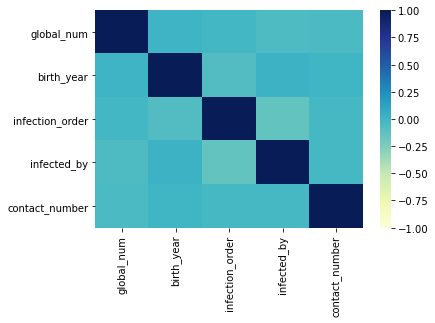

In [58]:
sns.heatmap(corr, center=0, cmap="YlGnBu", vmin=-1, vmax=1)

**<font color='teal'> Plot the boxplots to check for outliers. </font>**

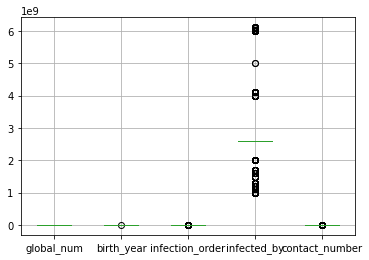

In [59]:
cols=list(corr.columns)
boxplot = df.boxplot(column=cols)

**<font color='teal'> Create dummy features for object type features. </font>**

In [60]:
df_with_dummies = pd.get_dummies(dfo)

In [61]:
df_with_dummies.shape

(1981, 291)

In [62]:
df_with_dummies

,sex_Unknown,sex_female,sex_male,age_0s,age_100s,age_10s,age_20s,age_30s,age_40s,age_50s,...,n_age_88.0,n_age_89.0,n_age_90.0,n_age_91.0,n_age_92.0,n_age_93.0,n_age_94.0,n_age_95.0,n_age_104.0,n_age_Unknown
patient_id,,,,,,,,,,,,,,,,,,,,,
1000000001,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1000000002,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1000000003,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1000000004,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1000000005,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6100000085,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7000000001,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7000000002,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
combined = pd.merge(dff, df_with_dummies, on='patient_id')

In [64]:
combined.head()

,global_num,birth_year,infection_order,infected_by,contact_number,state,sex_Unknown,sex_female,sex_male,age_0s,...,n_age_88.0,n_age_89.0,n_age_90.0,n_age_91.0,n_age_92.0,n_age_93.0,n_age_94.0,n_age_95.0,n_age_104.0,n_age_Unknown
patient_id,,,,,,,,,,,,,,,,,,,,,
1000000001,2.0,1964.0,1.0,2.600789e+09,75.0,released,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1000000002,5.0,1987.0,1.0,2.600789e+09,31.0,released,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1000000003,6.0,1964.0,2.0,2.002000e+09,17.0,released,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1000000004,7.0,1991.0,1.0,2.600789e+09,9.0,released,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1000000005,9.0,1992.0,2.0,1.000000e+09,2.0,released,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split the data into test and train subsamples

In [65]:
from sklearn.model_selection import train_test_split

# dont forget to define your X and y

X = combined.drop(columns='state')
y = combined['state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)

### Scale data to prep for model creation

In [66]:
#scale data
from sklearn import preprocessing
import numpy as np
# build scaler based on training data and apply it to test data to then also scale the test data
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [67]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

### Fit Random Forest Classifier
The fit model shows an overall accuracy of 80% which is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset.

In [68]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
y_pred_prob = model_res.predict_proba(X_test_scaled)
lr_probs = y_pred_prob[:,1]
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=1.000
Random Forest: f1-score=1.000


### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [69]:
class_names=['isolated','released','missing','deceased'] # name  of classes

Confusion matrix, without normalization
[[ 21   0   0   0]
 [  0   6   0   0]
 [  0   0 312   0]
 [  0   0   0  58]]
Normalized confusion matrix
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


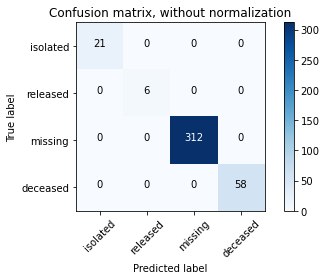

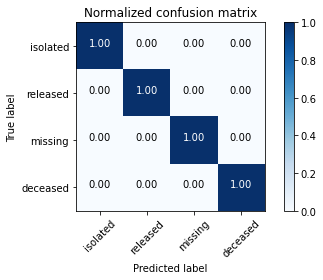

In [70]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

30


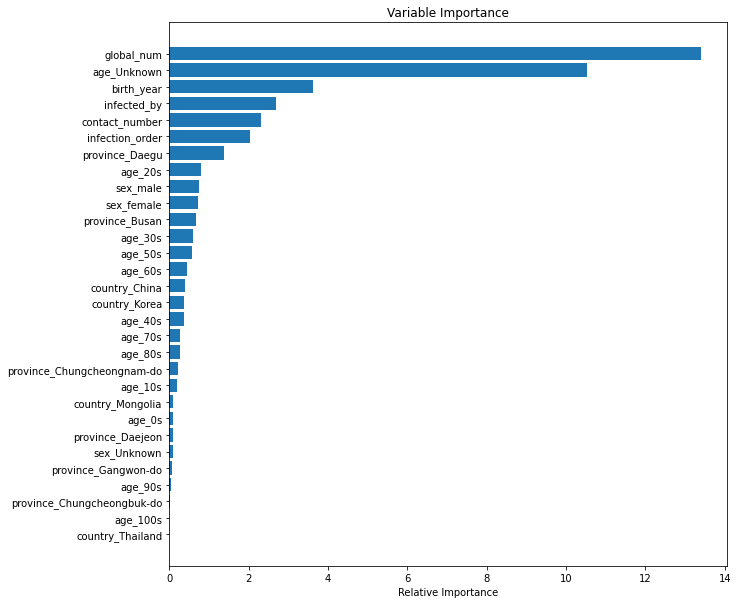

In [71]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:30]
sorted_idx = np.argsort(feature_importance)[:30]

pos = np.arange(sorted_idx.shape[0]) + .5
print(pos.size)
sorted_idx.size
plt.figure(figsize=(10,10))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

The popularity of random forest is primarily due to how well it performs in a multitude of data situations. It tends to handle highly correlated features well, where as a linear regression model would not. In this case study we demonstrate the performance ability even with only a few features and almost all of them being highly correlated with each other.
Random Forest is also used as an efficient way to investigate the importance of a set of features with a large data set. Consider random forest to be one of your first choices when building a decision tree, especially for multiclass classifications.